In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
import glob
import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from patchify import patchify, unpatchify

Segmentation Models: using `tf.keras` framework.


In [5]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

In [6]:
SIZE_X = 512
SIZE_Y = 512
BACKBONE = 'efficientnetb0'
activation = 'softmax'
encoder_freeze = False
num_classes = 3  # Adjust based on your channel definitions
dropout_value = 0.3
preprocess_input = sm.get_preprocessing(BACKBONE)
def create_model(dropout_value):
    # Build the model with the specified backbone
    model = sm.Unet(
        backbone_name=BACKBONE,
        input_shape=(SIZE_Y, SIZE_X, 3),  # Input image shape
        encoder_weights='imagenet',
        classes=num_classes,
        activation=None,  # No activation yet, we will add it after Dropout
        encoder_freeze=encoder_freeze
    )
    return model, preprocess_input
model, preprocess_input = create_model(dropout_value)
model.load_weights('../models/best_model_efficient.keras')

Overall Accuracy: 0.7972
Total No. of pixels misclassified: 1275746.0000
Total No. of pixels perfectly classified : 5015710.0000


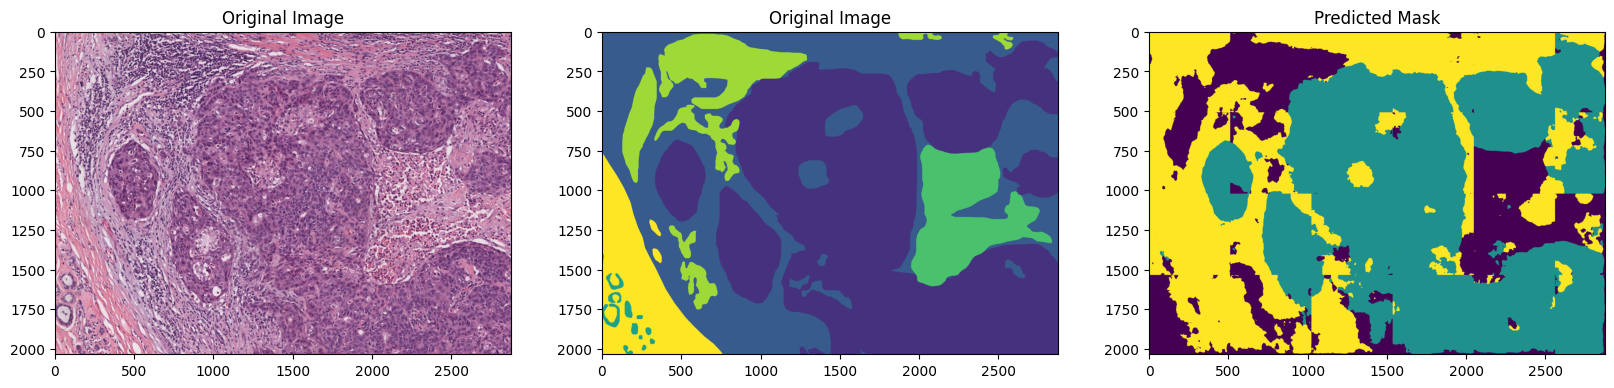

Overall Accuracy: 0.8360
Total No. of pixels misclassified: 859984.0000
Total No. of pixels perfectly classified : 4382896.0000


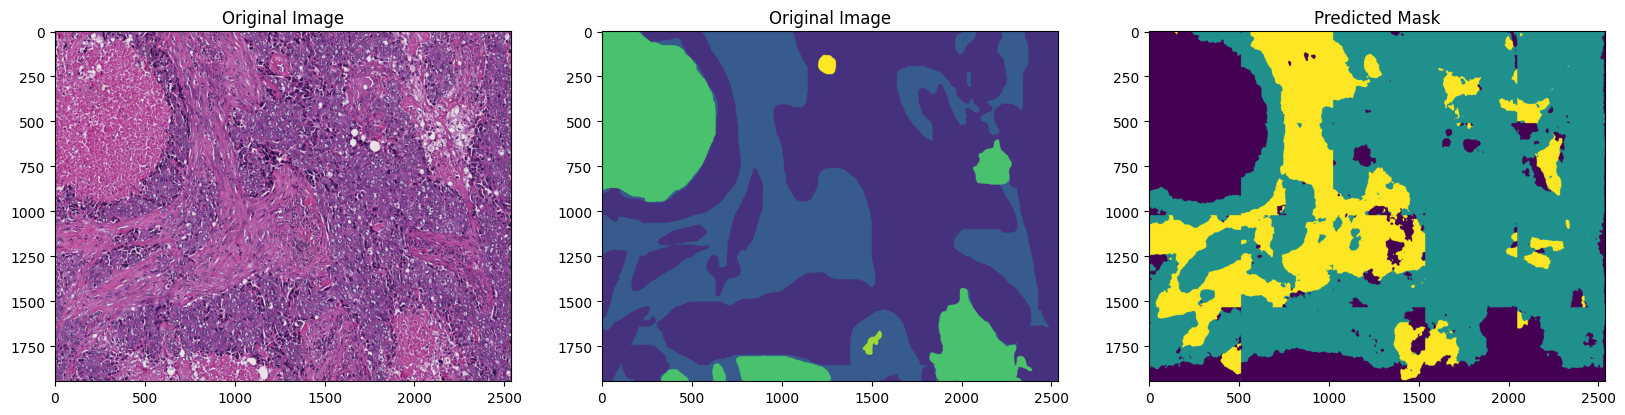

In [7]:
from patchify import patchify, unpatchify

total_same_pixels = 0
total_different_pixels = 0
total_pixels = 0

# Function to pad image to make dimensions divisible by the patch size
def pad_image(image, patch_size):
    pad_h = (patch_size - image.shape[0] % patch_size) % patch_size
    pad_w = (patch_size - image.shape[1] % patch_size) % patch_size
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
    return padded_image, pad_h, pad_w

# Function to remove padding from the reconstructed image
def remove_padding(reconstructed_image, pad_h, pad_w):
    if pad_h > 0:
        reconstructed_image = reconstructed_image[:-pad_h, :]
    if pad_w > 0:
        reconstructed_image = reconstructed_image[:, :-pad_w]
    return reconstructed_image

# Define patch size and directory for images
patch_size = 512
img_dir='../ti/t1/roi/tissue_bcss/images/'
image_paths = [f for f in os.listdir(img_dir) if f.endswith('.png') or f.endswith('.jpg')]
mask_dir='../ti/t1/roi/tissue_bcss/masks/'
masks_paths = [f for f in os.listdir(img_dir) if f.endswith('.png') or f.endswith('.jpg')]

# Iterate over each image in the directory
for img_path in image_paths[1:3]:
    pred_patches = []
    total_same_pixels = 0
    total_different_pixels = 0
    total_pixels = 0
    
    # Load the image
    big_image = cv2.imread(os.path.join(img_dir, img_path))
    big_mask = cv2.imread(os.path.join(mask_dir, img_path))
    if big_image is None or big_mask is None:
        print(f"Failed to load {img_path}")
        continue

    # Pad the image to make dimensions divisible by patch_size
    padded_image, pad_h, pad_w = pad_image(big_image, patch_size)
    padded_mask, pad_h, pad_w = pad_image(big_mask, patch_size)
    
    # Patchify the padded image
    img_patches = patchify(padded_image, (patch_size, patch_size, 3), step=patch_size).reshape(-1, patch_size, patch_size, 3)
    mask_patches = patchify(padded_mask, (patch_size, patch_size, 3), step=patch_size).reshape(-1, patch_size, patch_size, 3)
    
    # Predict on each patch
    for patch, msk_patch in zip(img_patches, mask_patches):
        patch = patch / 255.0
        patch = (patch - IMAGENET_MEAN) / IMAGENET_STD
        patch = np.expand_dims(patch, axis=0)
        
        # Model prediction
        predictions = model.predict(patch, verbose=0)
        y_pred = np.argmax(predictions, axis=3)
        final_patch = y_pred[0, :, :]  # Extract the predicted mask

        # Preprocess the mask_patch
        mask = np.where(msk_patch == 3, 0, msk_patch)  
        mask = np.where(mask == 4, 0, mask)  
        mask = np.where(mask == 5, 0, mask)  
        mask = np.where(mask == 6, 2, mask)  
        mask = np.where(mask == 7, 0, mask)

        # Reshape mask_patch for comparison
        # mask_en=tf.squeeze(mask, axis=-1)
        mask = mask[:, :, 0]  # Assuming mask has a third dimension and you want the first channel
        # mask_en = tf.squeeze(mask, axis=-1)
        # mask_oneHot = tf.one_hot(tf.cast(mask_en, tf.int32), depth=3)
        # plt.imshow(mask_oneHot[:,:,1])

        # Comparison between the predicted mask and the true mask
        same_pixels = np.sum(final_patch == mask)
        different_pixels = np.sum(final_patch != mask)

        # Update total pixel counts
        total_same_pixels += same_pixels
        total_different_pixels += different_pixels
        total_pixels += final_patch.size

        # Append the predicted and original patches for reconstruction
        pred_patches.append(final_patch)

# Calculate the average accuracy
    average_accuracy = total_same_pixels / total_pixels
    print(f"Overall Accuracy: {average_accuracy:.4f}")
    print(f"Total No. of pixels misclassified: {total_different_pixels:.4f}")
    print(f"Total No. of pixels perfectly classified : {total_same_pixels:.4f}")
    
    # Reshape pred_patches to form a grid
    h, w, _ = padded_image.shape
    n_patches_h = h // patch_size
    n_patches_w = w // patch_size
    pred_patches = np.array(pred_patches).reshape(n_patches_h, n_patches_w, patch_size, patch_size)
    
    # Unpatchify the patches back into the full mask
    predicted_mask = unpatchify(pred_patches, padded_image.shape[:2])
    
    # Remove the padding from the reconstructed mask
    predicted_mask = remove_padding(predicted_mask, pad_h, pad_w)
    
    # Display the original image and predicted mask
    plt.figure(figsize=(20, 20))

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(big_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow((big_mask[:,:,0]))
    plt.title(f"Original Image")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title(f"Predicted Mask")

    plt.show()

In [ ]:
from patchify import patchify, unpatchify

# Function to pad image to make dimensions divisible by the patch size
def pad_image(image, patch_size):
    pad_h = (patch_size - image.shape[0] % patch_size) % patch_size
    pad_w = (patch_size - image.shape[1] % patch_size) % patch_size
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
    return padded_image, pad_h, pad_w

# Function to remove padding from the reconstructed image
def remove_padding(reconstructed_image, pad_h, pad_w):
    if pad_h > 0:
        reconstructed_image = reconstructed_image[:-pad_h, :]
    if pad_w > 0:
        reconstructed_image = reconstructed_image[:, :-pad_w]
    return reconstructed_image

# Define patch size and directory for images
patch_size = 512
img_dir = 'ti\\t1\\roi\\tissue_bcss\masks'
image_paths = [f for f in os.listdir(img_dir) if f.endswith('.png') or f.endswith('.jpg')]

for img_path in image_paths:
    pred_patches = []
    
    # Load the image
    big_image = cv2.imread(os.path.join(img_dir, img_path))
    if big_image is None:
        print(f"Failed to load {img_path}")
        continue  # Skip to the next image if loading fails

    # Pad the image to make dimensions divisible by patch_size
    padded_image, pad_h, pad_w = pad_image(big_image, patch_size)
    
    # Patchify the padded image
    img_patches = patchify(padded_image, (patch_size, patch_size, 3), step=patch_size).reshape(-1, patch_size, patch_size, 3)
    
    # Predict on each patch
    for patch in img_patches:
        mask = np.where(patch == 3, 0, patch)  # Set 3 to 0.0
        mask = np.where(mask == 4, 0, mask)  # Set 4 to 0.0
        mask = np.where(mask == 5, 0, mask)  # Set 5 to 0.0
        mask = np.where(mask == 6, 2, mask)  # Set 6 to 2.0
        mask = np.where(mask == 7, 0, mask)
        print(mask.shape)
        print(mask[:,:,0])
        plt.imshow(mask)
        pred_patches.append(mask)
    break

In [ ]:
msks=cv2.imread('ti\\t1\\roi\\tissue_cells\masks\\100B_[10779, 11621, 12102, 12874].png')
# print(msks)
plt.imshow(msks[:,:,0])